# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install category_encoders

     |████████████████████████████████| 81 kB 34 kB/s  eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn
import category_encoders as ce
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import time

In [3]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Признаки**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

Заметно, что в датасете есть пропуски, а также ненужные для обучения столбцы:

* DateCrawled — дата скачивания анкеты из базы
* RegistrationMonth — месяц регистрации автомобиля
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Впоследствии от них нужно будет избавиться, а затем обработать пропуски, но сначала проверить датасет на аномалии.

<AxesSubplot:>

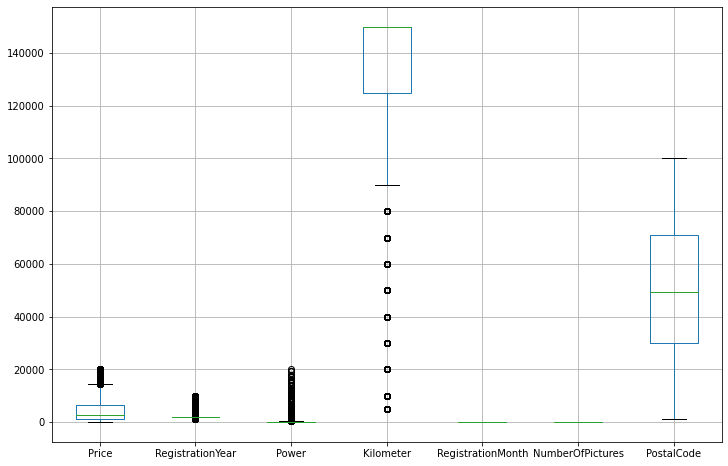

In [6]:
data.boxplot(figsize=(12,8))

Заметно много выбросов в RegistrationYear и Power. Их нужно изучить детальнее, а также проверить уникальные значения в строковых параметрах.

In [7]:
for column in data.columns:
    print('Уникальные значения столбца', column)
    print(data[column].unique())
    print()

Уникальные значения столбца DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']

Уникальные значения столбца Price
[  480 18300  9800 ... 12395 18429 10985]

Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения столбца RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2

В столбцах RegistrationYear и Power есть явно некорректные значения. Выведем их на гистограмме, как и остальные численные.

<AxesSubplot:>

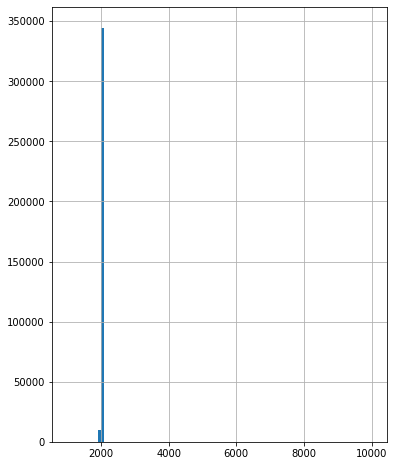

In [8]:
def histogram(data, bins, size):
    return data.hist(bins=bins, figsize=size)

histogram(data['RegistrationYear'], 100, (6,8))

<AxesSubplot:>

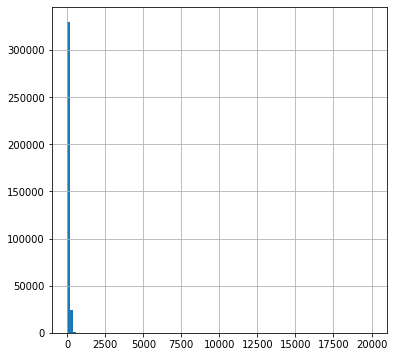

In [9]:
histogram(data['Power'], 100, (6,6))

<AxesSubplot:>

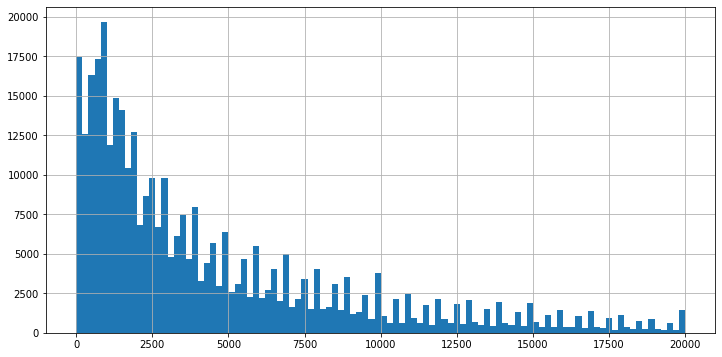

In [10]:
histogram(data['Price'], 100, (12,6))

В столбце Price довольно много строк с ценой 0. Посчитаем их точное число:

In [11]:
data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Отфильтруем в отдельный датафрейм нужные для обучения столбцы (не перезаписываем оригинальный на случай, если удалённые ещё понадобятся).

In [12]:
for_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
data_filtered = data.drop(for_drop, axis=1)
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Нужно удалить значения цены 0, т.к. они являются следствием какой-то ошибки в данных.

<AxesSubplot:>

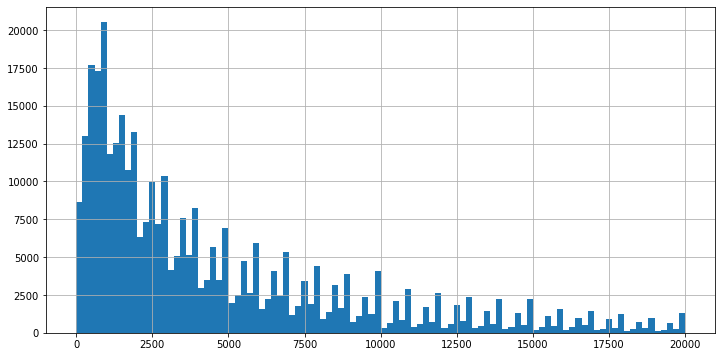

In [13]:
data_filtered = data_filtered.loc[data_filtered['Price'] > 0]
histogram(data_filtered['Price'], 100, (12,6))

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

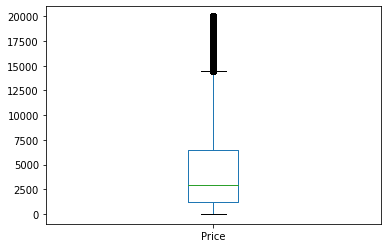

In [14]:
data_filtered['Price'].plot.box()
data_filtered['Price'].describe()

In [15]:
data_filtered['Price'].quantile([0.05, 0.95])

0.05      350.0
0.95    14800.0
Name: Price, dtype: float64

Интервал 5%-95% - от 350 до 14800 евро, но дальше трогать цену не будем, т.к. её значения могут быть самыми разными. Теперь проверим значения столбца RegistrationYear, т.к. там тоже наблюдались некорректные.

count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

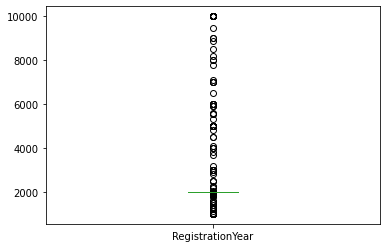

In [16]:
data_filtered['RegistrationYear'].plot.box()
data_filtered['RegistrationYear'].describe()

В столбце года регистрации много некорректных очень больших значений. Попробуем их отсечь, используя исходный датафрейм и столбец DateCrawled.

In [17]:
date = pd.to_datetime(data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Дат регистрации после 2016 года нет. Не могут они быть и раньше 1885 (год изобретения автомобиля). Отсечём эти даты и посмотрим распределение по годам.

count    329765.000000
mean       2002.593583
std           6.927865
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

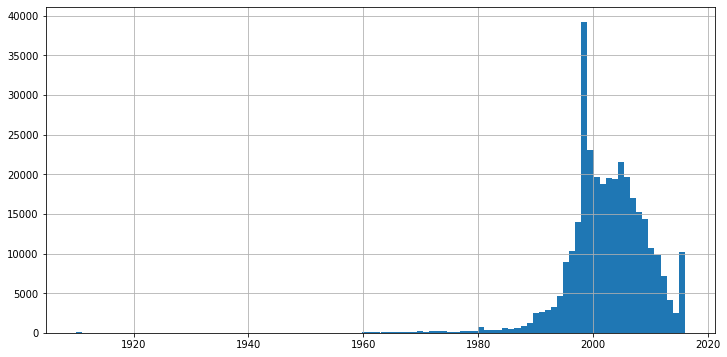

In [18]:
data_filtered = data_filtered.loc[(data_filtered['RegistrationYear'] > 1885) & (data_filtered['RegistrationYear'] <= 2016)]
histogram(data_filtered['RegistrationYear'], 100, (12,6))
data_filtered['RegistrationYear'].describe()

Реалистичный минимальный год - 1960. Также отсеем явно некорректные значения мощности.

count    296528.000000
mean       2002.842625
std           6.438744
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

count    296528.000000
mean        120.882342
std          55.925854
min           1.000000
25%          75.000000
50%         111.000000
75%         150.000000
max        1200.000000
Name: Power, dtype: float64

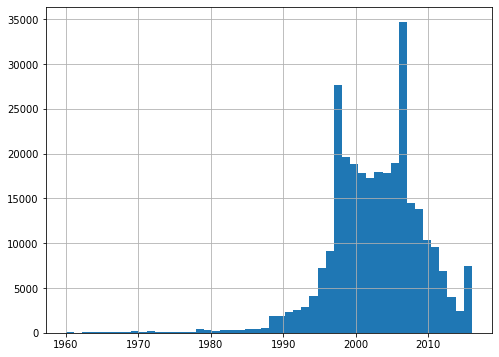

In [19]:
data_filtered = data_filtered.loc[(data_filtered['RegistrationYear'] >= 1960) & 
                                  (data_filtered['RegistrationYear'] <= 2016) &
                                  (data_filtered['Power'] > 0) &
                                 (data_filtered['Power'] <= 1200)]
histogram(data_filtered['RegistrationYear'], 50, (8,6))
display(data_filtered['RegistrationYear'].describe())
data_filtered['Power'].describe()

<AxesSubplot:>

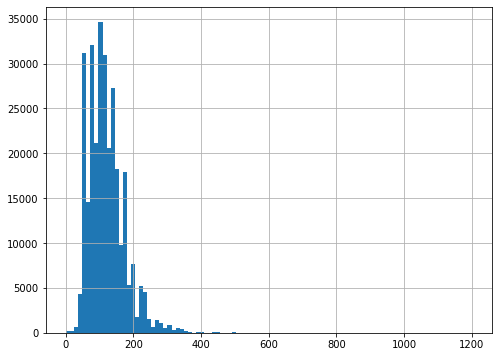

In [20]:
histogram(data_filtered['Power'], 100, (8,6))

Пропуски заполняем значением Unknown, что создаст отдельную категорию.

In [21]:
data_filtered.fillna(value='Unknown', inplace=True)
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296528 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296528 non-null  int64 
 1   VehicleType       296528 non-null  object
 2   RegistrationYear  296528 non-null  int64 
 3   Gearbox           296528 non-null  object
 4   Power             296528 non-null  int64 
 5   Model             296528 non-null  object
 6   Kilometer         296528 non-null  int64 
 7   FuelType          296528 non-null  object
 8   Brand             296528 non-null  object
 9   Repaired          296528 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


## Обучение моделей

Задействуем технику прямого кодирования, чтобы преобразовать категориальные признаки в численные.

In [40]:
# назначение типа category для LGBM/CatBoost
for col in categorical:
    data_filtered[col] = data_filtered[col].astype('category')

# выделение признаков и цели
features = data_filtered.drop(['Price'], axis=1)
target = data_filtered['Price']

# разбиение на начальные выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [41]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# Target Encoding для избавления от проклятия размерности; закодированные признаки для линейных моделей
encoder = ce.TargetEncoder(cols=categorical)
features_train_lin = encoder.fit_transform(features_train, target_train)
features_test_lin = encoder.transform(features_test)

In [29]:
def rmse(target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

Теперь обучим и проанализируем время работы и качество моделей.

### Линейная регрессия

In [30]:
lin_model = LinearRegression()

In [42]:
%%time
lin_model.fit(features_train_lin, target_train)

CPU times: user 35.5 ms, sys: 16.1 ms, total: 51.6 ms
Wall time: 40.6 ms


LinearRegression()

In [32]:
%%time
predicted_lin = pd.Series(lin_model.predict(features_test_lin))
rmse(target_test, predicted_lin)

CPU times: user 14.6 ms, sys: 1.59 ms, total: 16.2 ms
Wall time: 5.89 ms


2793.2292088643185

### CatBoostRegressor

Тестируем в двух циклах с различными значениями гиперпараметров iterations и depth.

In [33]:
for iteration in range(10, 111, 20):
    cbr_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10, verbose=10, 
                                  cat_features=categorical)
    cbr_cv = cross_val_score(cbr_model, features_train, target_train, cv=2)
    print("Iterations =", iteration, "Score:", cbr_cv)
    print("Score mean =", sum(cbr_cv)/len(cbr_cv))
    print()

Learning rate set to 0.5
0:	learn: 3117.6733873	total: 142ms	remaining: 1.27s
9:	learn: 1744.2130201	total: 704ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3118.5714723	total: 70.8ms	remaining: 637ms
9:	learn: 1753.5013695	total: 623ms	remaining: 0us
Iterations = 10 Score: [0.84795642 0.84970312]
Score mean = 0.8488297657644303

Learning rate set to 0.5
0:	learn: 3117.6733873	total: 65.8ms	remaining: 1.91s
10:	learn: 1728.6034232	total: 675ms	remaining: 1.17s
20:	learn: 1637.4990369	total: 1.28s	remaining: 547ms
29:	learn: 1579.3251287	total: 1.82s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3118.5714723	total: 71ms	remaining: 2.06s
10:	learn: 1740.2040122	total: 683ms	remaining: 1.18s
20:	learn: 1638.1902651	total: 1.29s	remaining: 553ms
29:	learn: 1581.4146570	total: 1.8s	remaining: 0us
Iterations = 30 Score: [0.86472218 0.86663006]
Score mean = 0.8656761228816706

Learning rate set to 0.5
0:	learn: 3117.6733873	total: 64.5ms	remaining: 3.16s
10:	learn: 1728.6034232	tot

In [34]:
for depth in range(5, 16, 2):
    cbr_model = CatBoostRegressor(loss_function="RMSE", iterations=20, depth=depth, verbose=10, cat_features=categorical)
    cbr_cv = cross_val_score(cbr_model, features_train, target_train, cv=2)
    print("Depth =", depth, "Score:", cbr_cv)
    print("Score mean =", sum(cbr_cv)/len(cbr_cv))
    print()

Learning rate set to 0.5
0:	learn: 3359.6445717	total: 40.3ms	remaining: 766ms
10:	learn: 1946.9301237	total: 366ms	remaining: 299ms
19:	learn: 1849.6940807	total: 656ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3313.9460901	total: 38.1ms	remaining: 724ms
10:	learn: 1953.8471543	total: 363ms	remaining: 297ms
19:	learn: 1868.2174151	total: 648ms	remaining: 0us
Depth = 5 Score: [0.83641873 0.83521529]
Score mean = 0.8358170081582936

Learning rate set to 0.5
0:	learn: 3217.2267713	total: 47.7ms	remaining: 907ms
10:	learn: 1847.7890186	total: 482ms	remaining: 394ms
19:	learn: 1768.2999609	total: 841ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3204.4061887	total: 48.3ms	remaining: 919ms
10:	learn: 1852.0984077	total: 477ms	remaining: 391ms
19:	learn: 1755.1379216	total: 841ms	remaining: 0us
Depth = 7 Score: [0.84734907 0.85203777]
Score mean = 0.8496934199401237

Learning rate set to 0.5
0:	learn: 3145.4278589	total: 65.3ms	remaining: 1.24s
10:	learn: 1762.1675292	total: 62

С ростом глубины/итераций точность сначала растёт, но потом становится стабильной. Останавливаемся на значениях iterations=90, depth=13 (они ещё достаточно быстрые, но при этом почти максимально точные).

In [35]:
%%time
cbr_model = CatBoostRegressor(loss_function="RMSE", iterations=90, depth=13, verbose=10)
cbr_model.fit(features_train, target_train, cat_features=categorical)

Learning rate set to 0.5
0:	learn: 3065.9019218	total: 213ms	remaining: 18.9s
10:	learn: 1644.5679207	total: 2.27s	remaining: 16.3s
20:	learn: 1525.2261133	total: 4.32s	remaining: 14.2s
30:	learn: 1459.1872334	total: 6.42s	remaining: 12.2s
40:	learn: 1405.2673409	total: 8.5s	remaining: 10.2s
50:	learn: 1363.7531351	total: 10.6s	remaining: 8.07s
60:	learn: 1336.5873341	total: 12.6s	remaining: 5.98s
70:	learn: 1313.5680836	total: 14.7s	remaining: 3.93s
80:	learn: 1294.9715678	total: 16.7s	remaining: 1.86s
89:	learn: 1276.5483257	total: 18.6s	remaining: 0us
CPU times: user 19 s, sys: 43.7 ms, total: 19 s
Wall time: 19.5 s


In [36]:
%%time
predictions_cbr = pd.Series(cbr_model.predict(features_test))

CPU times: user 98.3 ms, sys: 4.11 ms, total: 102 ms
Wall time: 101 ms


In [37]:
rmse(target_test, predictions_cbr)

1566.9316801785099

### LightGBM

In [43]:
params = {
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0,
    'num_leaves': 32 # число листьев - меньше или равно 2^max_depth
}

lgbm_model = LGBMRegressor(**params)

In [44]:
%%time
lgbm_model.fit(features_train, target_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

LGBMRegressor(boosting='gbdt', max_depth=6, metric='rmse', num_leaves=32,
              objective='regression', verbose=0)

In [45]:
%%time
predictions_lgbm = lgbm_model.predict(features_test)

CPU times: user 708 ms, sys: 0 ns, total: 708 ms
Wall time: 663 ms


In [46]:
rmse(target_test, predictions_lgbm)

1610.168923139173

### Ridge

In [47]:
ridge_model = Ridge(random_state=12345)
solvers = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]

grid_search = GridSearchCV(ridge_model, solvers, scoring='neg_mean_squared_error')
grid_search.fit(features_train_lin, target_train)
print("Лучшие параметры:")
print()
print(grid_search.best_params_)
print()
print("Значения RMSE с разными параметрами:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_rmse = (max(means)*-1) ** 0.5

Лучшие параметры:

{'solver': 'auto'}

Значения RMSE с разными параметрами:

2775.149404 for {'solver': 'auto'}
2775.149404 for {'solver': 'svd'}
2775.149404 for {'solver': 'cholesky'}
3210.257632 for {'solver': 'lsqr'}
3210.257632 for {'solver': 'sparse_cg'}



## Анализ моделей

Обучим каждую модель с лучшими параметрами, предскажем ею данные на тестовой выборке и сравним время и результаты.

#### Линейная регрессия

In [48]:
%%time
model = LinearRegression()
start = time.time()
model.fit(features_train_lin, target_train)
end = time.time()
fit_time_lin = end - start

CPU times: user 36.3 ms, sys: 8.05 ms, total: 44.4 ms
Wall time: 32.2 ms


In [49]:
%%time
target_predict = model.predict(features_test_lin)
pred_time_lin = time.time() - end

CPU times: user 6.26 ms, sys: 176 µs, total: 6.44 ms
Wall time: 4.27 ms


In [50]:
rmse_lin = rmse_lin = rmse(target_test, target_predict)

#### Ridge

In [51]:
%%time
model = Ridge(random_state=12345, solver='auto')
start = time.time()
model.fit(features_train_lin, target_train)
end = time.time()
fit_time_ridge = end - start

CPU times: user 15.7 ms, sys: 294 µs, total: 16 ms
Wall time: 13.8 ms


In [52]:
%%time
target_predict = model.predict(features_test_lin)
pred_time_ridge = time.time() - end

CPU times: user 25.8 ms, sys: 1.76 ms, total: 27.6 ms
Wall time: 6.21 ms


In [53]:
rmse_ridge = rmse(target_test, target_predict)

#### CatBoost

In [54]:
%%time
model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=12345, 
                          iterations=90, depth=13,
                         cat_features=categorical,
                         verbose=False)
start = time.time()
model.fit(features_train, target_train)
end = time.time()
fit_time_cat = end - start

CPU times: user 18.9 s, sys: 107 ms, total: 19 s
Wall time: 19.7 s


In [55]:
%%time
target_predict = model.predict(features_test)
pred_time_cat = time.time() - end

CPU times: user 58.2 ms, sys: 7.6 ms, total: 65.9 ms
Wall time: 64.6 ms


In [56]:
rmse_cat = rmse(target_test, target_predict)

#### LGBM

In [57]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6,
    'num_leaves': 32,
    'learning_rate': 0.1,
    'verbose': -1,
    'min_data_in_leaf': 100
}
model = LGBMRegressor(**params)
start = time.time()

In [58]:
%%time
model.fit(features_train, target_train)
end = time.time()
fit_time_lgbm = end - start

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
CPU times: user 4.09 s, sys: 0 ns, total: 4.09 s
Wall time: 4.05 s


In [59]:
%%time
target_predict = model.predict(features_test)
pred_time_lgbm = time.time() - end

CPU times: user 697 ms, sys: 0 ns, total: 697 ms
Wall time: 705 ms


In [60]:
rmse_lgbm = rmse(target_test, target_predict)

Итоги сведём в таблицу:

In [61]:
models = [['Linear', fit_time_lin, pred_time_lin, rmse_lin], ['Ridge', fit_time_ridge, pred_time_ridge, rmse_ridge], 
          ['CatBoost', fit_time_cat, pred_time_cat, rmse_cat], ['LGBM', fit_time_lgbm, pred_time_lgbm, rmse_lgbm]] 
    
results = pd.DataFrame(models, columns =['Модель', 'Время обучения, с', 'Время работы, мс', 'RMSE']) 
results

,Модель,"Время обучения, с","Время работы, мс",RMSE
0,Linear,0.032158,2.650946,2793.229209
1,Ridge,0.013722,0.457014,2793.229211
2,CatBoost,19.678305,0.069015,1559.700747
3,LGBM,4.060778,0.712190,1618.451318


### Вывод

В ходе работы было выполнено:

* Загружены данные и проведена предобработка с удалением аномалий и заполнением пропусков.
* Выполнено сравнение моделей (Linear Regression, Ridge, LightGBM, CatBoost) с использованием различных наборов гиперпараметров.
* Выбрана лучшая модель по результатам метрики RMSE и времени предсказания.

На выбор модели не влияло время обучения, так как обучается она однократно, а предсказания приходится делать много раз.
* Метрика RMSE лучше всего выглядит у моделей с градиентным бустингом - LGBM и CatBoost, но время их работы значительно дольше, чем у линейной регрессии и Ridge.
* Быстрее всего обучается/предсказывает модель Ridge, но её точность оставляет желать лучшего.
* У модели CatBoostRegressor относительно небольшое время обучения/работы и хорошая точность. Таким образом, она является лучшей в данном списке.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей